In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import sys
import rosbag2_py
from create_std_bag import get_rosbag_options
from rosidl_runtime_py.utilities import get_message
from rclpy.serialization import deserialize_message
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.transform import Rotation
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

Images & Labels

In [2]:
def read_label_file(label_path, label_dir):
    with open(os.path.join(label_dir, label_path), 'r') as file:
        label_contents = [line.strip() for line in file.readlines()]
    return label_contents

def solve_pnp(gate_corners, image_corners, intrinsics, distortion):
    _, rvec, tvec = cv2.solvePnP(gate_corners, image_corners, intrinsics, distortion)
    return rvec, tvec

def create_dfs(flight):
    flight_type = "piloted" if "p-" in flight else "autonomous"
    flight_dir = os.path.join("..", "data", flight_type, flight)

    image_dir = os.path.join(flight_dir, "camera_" + flight + "/")
    label_dir = os.path.join(flight_dir, "label_" + flight + "/")
    csv_df = pd.read_csv(os.path.join(flight_dir, flight + "_cam_ts_sync.csv"))
    image_paths = [os.path.basename(filename) for filename in os.listdir(image_dir)]
    label_paths = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
    df = pd.DataFrame({'image': image_paths})
    df['label'] = df['image'].apply(lambda x: next((os.path.basename(label_path) for label_path in label_paths if os.path.basename(label_path)[:5] == x[:5]), np.nan))
    df.sort_values(by='image', key=lambda x: x.str[:5], inplace=True, ignore_index=True)
    df['timestamp'] = csv_df['timestamp']
    df['drone_x'] = csv_df['drone_x']
    df['drone_y'] = csv_df['drone_y']
    df['drone_z'] = csv_df['drone_z']
    df['drone_roll'] = csv_df['drone_roll']
    df['drone_pitch'] = csv_df['drone_pitch']
    df['drone_yaw'] = csv_df['drone_yaw']
    df['label_content'] = df['label'].apply(lambda x: read_label_file(x, label_dir) if not pd.isnull(x) else None)
    df['label_dict'] = df['label_content'].apply(lambda x: [dict(zip(['label', 'cx', 'cy', 'w', 'h', 'tlx', 'tly', 'tlv', 'trx', 'try', 'trv', 'brx', 'bry', 'brv', 'blx', 'bly', 'blv'], item.split())) for item in x] if x else None)
    df.drop(columns=['label_content'], inplace=True)
    image_size = (640, 480)
    df['label_dict'] = df['label_dict'].apply(lambda x: [{k: float(v) * image_size[0] if k in ['cx', 'tlx', 'trx', 'brx', 'blx', 'w'] else float(v) * image_size[1] if k in ['cy', 'tly', 'try', 'bry', 'bly', 'h'] else v for k, v in item.items()} for item in x] if x else None)
    calibration_results = "../camera_calibration/calibration_results.npz"
    intrinsics, distortion = np.load(calibration_results).values()
    gate_size = 1.523
    gate_corners = np.array([[-gate_size/2, gate_size/2, 0], [gate_size/2, gate_size/2, 0], [gate_size/2, -gate_size/2, 0], [-gate_size/2, -gate_size/2, 0]])

    pnp_estimates = []
    for label_dict in df['label_dict']:
        per_gate_estimates = []
        if label_dict:
            for label in label_dict:
                image_corners = np.array([[label['tlx'], label['tly']], [label['trx'], label['try']], [label['brx'], label['bry']], [label['blx'], label['bly']]])
                if (image_corners > 0).all():
                    rvec, tvec = solve_pnp(gate_corners, image_corners, intrinsics, distortion)
                    per_gate_estimates.append({'rvec': rvec, 'tvec': tvec})
                else:
                    per_gate_estimates.append({})
        pnp_estimates.append(per_gate_estimates)

    df['pnp_estimates'] = pnp_estimates

    bag_path = os.path.join(flight_dir, f"ros2bag_{flight}")
    imu_df = pd.DataFrame(columns=["timestamp", "accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"])
    channels_df = pd.DataFrame(columns=["timestamp", "channels_roll", "channels_pitch", "channels_thrust", "channels_yaw"])

    storage_options, converter_options = get_rosbag_options(bag_path, 'sqlite3')
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)

    topic_types = reader.get_all_topics_and_types()
    type_map = {topic_types[i].name: topic_types[i].type for i in range(len(topic_types))}

    storage_filter = rosbag2_py.StorageFilter(topics=['/sensors/imu', '/fc/sent/channels'])
    reader.set_filter(storage_filter)

    imu_data_list = []
    channels_data_list = []

    while reader.has_next():
            (topic, data, _) = reader.read_next()
            msg_type = get_message(type_map[topic])
            if(msg_type.__name__ == 'SensorImu'):
                imu_data = deserialize_message(data, msg_type)
                imu_data_list.append({
                    "timestamp": imu_data.timestamp,
                    "accel_x": imu_data.accel_x,
                    "accel_y": imu_data.accel_y,
                    "accel_z": imu_data.accel_z,
                    "gyro_x": imu_data.gyro_x,
                    "gyro_y": imu_data.gyro_y,
                    "gyro_z": imu_data.gyro_z,
                })
            if(msg_type.__name__ == 'RcChannels'):
                channels_data = deserialize_message(data, msg_type)
                channels_data_list.append({
                    "timestamp": channels_data.timestamp,
                    "channels_roll": channels_data.channels[0],
                    "channels_pitch": channels_data.channels[1],
                    "channels_thrust": channels_data.channels[2],
                    "channels_yaw": channels_data.channels[3],
                })

    del reader

    imu_df = pd.DataFrame(imu_data_list)
    channels_df = pd.DataFrame(channels_data_list)

    imu_df = imu_df[imu_df['timestamp'] >= df['timestamp'].min()]
    imu_df = imu_df[imu_df['timestamp'] <= df['timestamp'].max()]
    channels_df = channels_df[channels_df['timestamp'] >= df['timestamp'].min()]
    channels_df = channels_df[channels_df['timestamp'] <= df['timestamp'].max()]

    # Normalize imu_df
    imu_features = imu_df.columns[1:]  # Exclude the 'timestamp' column
    imu_df[imu_features] = MinMaxScaler().fit_transform(imu_df[imu_features])

    # Normalize channels_df
    channels_features = channels_df.columns[1:]  # Exclude the 'timestamp' column
    channels_df[channels_features] = MinMaxScaler().fit_transform(channels_df[channels_features])

    # Normalize 'drone_x', 'drone_y', and 'drone_z' columns
    columns_to_normalize = ['drone_x', 'drone_y', 'drone_z']
    df[columns_to_normalize] = StandardScaler().fit_transform(df[columns_to_normalize])

    columns_to_normalize = ['drone_roll', 'drone_pitch', 'drone_yaw']
    df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

    # # Convert roll, pitch, and yaw angles to quaternions
    # r = Rotation.from_euler('xyz', df[['drone_roll', 'drone_pitch', 'drone_yaw']], degrees=True)
    # quaternions = r.as_quat()

    # # Include quaternions in the dataframe
    # df['quaternion_x'] = quaternions[:, 0]
    # df['quaternion_y'] = quaternions[:, 1]
    # df['quaternion_z'] = quaternions[:, 2]
    # df['quaternion_w'] = quaternions[:, 3]
    df = df.loc[(df['timestamp'] >= imu_df.iloc[199]['timestamp']) & (df['timestamp'] >= channels_df.iloc[109]['timestamp'])]
    return df, imu_df, channels_df


In [15]:
flight1_df, flight1_imu_df, flight1_channels_df = create_dfs('flight-01a-ellipse')
flight2_df, flight2_imu_df, flight2_channels_df = create_dfs('flight-02a-ellipse')
flight3_df, flight3_imu_df, flight3_channels_df = create_dfs('flight-03a-ellipse')
flight4_df, flight4_imu_df, flight4_channels_df = create_dfs('flight-04a-ellipse')
flight5_df, flight5_imu_df, flight5_channels_df = create_dfs('flight-05a-ellipse')

[INFO] [1705315416.893943416] [rosbag2_storage]: Opened database '../data/autonomous/flight-01a-ellipse/ros2bag_flight-01a-ellipse/ros2bag_flight-01a-ellipse.db3' for READ_ONLY.
[INFO] [1705315419.435451138] [rosbag2_storage]: Opened database '../data/autonomous/flight-02a-ellipse/ros2bag_flight-02a-ellipse/ros2bag_flight-02a-ellipse.db3' for READ_ONLY.
[INFO] [1705315422.107453351] [rosbag2_storage]: Opened database '../data/autonomous/flight-03a-ellipse/ros2bag_flight-03a-ellipse/ros2bag_flight-03a-ellipse.db3' for READ_ONLY.
[INFO] [1705315425.527055400] [rosbag2_storage]: Opened database '../data/autonomous/flight-04a-ellipse/ros2bag_flight-04a-ellipse/ros2bag_flight-04a-ellipse.db3' for READ_ONLY.
[INFO] [1705315428.101050328] [rosbag2_storage]: Opened database '../data/autonomous/flight-05a-ellipse/ros2bag_flight-05a-ellipse/ros2bag_flight-05a-ellipse.db3' for READ_ONLY.


In [16]:
all_flight_dfs = pd.concat([flight1_df, flight2_df, flight3_df, flight4_df, flight5_df], ignore_index=True)
all_flight_imu_dfs = pd.concat([flight1_imu_df, flight2_imu_df, flight3_imu_df, flight4_imu_df, flight5_imu_df], ignore_index=True)
all_flight_channels_dfs = pd.concat([flight1_channels_df, flight2_channels_df, flight3_channels_df, flight4_channels_df, flight5_channels_df], ignore_index=True)

In [6]:
import matplotlib.pyplot as plt

def show_image_with_labels(frame_number, flight_df, flight):
    flight_type = "piloted" if "p-" in flight else "autonomous"
    flight_dir = os.path.join("..", "data", flight_type, flight)

    image_dir = os.path.join(flight_dir, "camera_" + flight + "/")
    frame_number = str(frame_number).zfill(5)
    labels = flight_df.loc[flight_df['image'].str[:5] == frame_number, 'label_dict'].values[0]
    pnp_estimates = flight_df.loc[flight_df['image'].str[:5] == frame_number, 'pnp_estimates'].values[0]
    image_path = flight_df.loc[flight_df['image'].str[:5] == frame_number, 'image'].values[0]
    image = cv2.imread(os.path.join(image_dir, image_path))
    if labels:
        for label in labels:
            tlx, tly = int(label['tlx']), int(label['tly'])
            trx, try_ = int(label['trx']), int(label['try'])
            brx, bry = int(label['brx']), int(label['bry'])
            blx, bly = int(label['blx']), int(label['bly'])
            
            cv2.circle(image, (tlx, tly), 5, (255, 0, 0), -1)
            cv2.circle(image, (trx, try_), 5, (0, 255, 0), -1)
            cv2.circle(image, (brx, bry), 5, (0, 0, 255), -1)
            cv2.circle(image, (blx, bly), 5, (255, 255, 0), -1)
    calibration_results = "../camera_calibration/calibration_results.npz"
    intrinsics, distortion = np.load(calibration_results).values()
    gate_size = 1.523
    gate_corners = np.array([[-gate_size/2, gate_size/2, 0], [gate_size/2, gate_size/2, 0], [gate_size/2, -gate_size/2, 0], [-gate_size/2, -gate_size/2, 0]])
    for pnp_estimate in pnp_estimates:
        rvec = pnp_estimate.get('rvec')
        tvec = pnp_estimate.get('tvec')
        if rvec is not None and tvec is not None:
            image_points, _ = cv2.projectPoints(gate_corners, rvec, tvec, intrinsics, distortion)
            image_points = np.int32(image_points).reshape(-1, 2)
            cv2.drawFrameAxes(image, intrinsics, distortion, rvec, tvec, gate_size/2)
            cv2.polylines(image, [image_points], True, (0, 255, 255), 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()


In [7]:
flight_df = flight5_df
# Define the slider range
slider_range = widgets.IntSlider(min=0, max=len(flight_df)-1, step=1, value=0)

# Define the function to display the image with labels
@interact(frame_number=slider_range)
def show_image_with_labels_slider(frame_number):
    show_image_with_labels(frame_number, flight5_df, 'flight-05a-ellipse')


interactive(children=(IntSlider(value=0, description='frame_number', max=2724), Output()), _dom_classes=('widg…

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, imu_df, channels_df, df, imu_queue_size=200, channels_queue_size=110):
        self.imu_df = imu_df
        self.imu_queue_size = imu_queue_size
        self.channels_df = channels_df
        self.channels_queue_size = channels_queue_size
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        timestamp = self.df.iloc[index]['timestamp']
        label = torch.tensor(self.df[['drone_x', 'drone_y', 'drone_z', 'drone_roll', 'drone_pitch', 'drone_yaw']].values.astype(np.float32))[index]
        imu_readings = self.imu_df[self.imu_df['timestamp'] <= timestamp].tail(self.imu_queue_size)
        channels_readings = self.channels_df[self.channels_df['timestamp'] <= timestamp].tail(self.channels_queue_size)
        imu_tensor = torch.tensor(imu_readings[['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']].values.astype(np.float32))
        channels_tensor = torch.tensor(channels_readings[['channels_roll', 'channels_pitch', 'channels_thrust', 'channels_yaw']].values.astype(np.float32))
        return (imu_tensor, channels_tensor, label, imu_readings['timestamp'].values, channels_readings['timestamp'].values)

class CustomDataLoader:
    def __init__(self, imu_df, channels_df, df, batch_size, shuffle=True):
        self.dataset = CustomDataset(imu_df, channels_df, df)
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def get_data_loader(self):
        return DataLoader(
            dataset=self.dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle
        )


In [6]:
from fastai.torch_basics import *
from fastai.tabular.core import *

from torch.nn.utils import weight_norm

class Chomp1d(Module):
    def __init__(self, chomp_size):
        store_attr()
    
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

    
def get_conv_block(n_inputs, n_outputs, kernel_size, stride, padding, dilation, dropout):
    conv  = weight_norm(nn.Conv1d(n_inputs, 
                                  n_outputs, 
                                  kernel_size,
                                  stride=stride, 
                                  padding=padding,
                                  dilation=dilation
                                  ))
    chomp = Chomp1d(padding)
    relu  = nn.ReLU()
    drop  = nn.Dropout(dropout)

    return nn.Sequential(*(conv, chomp,
                           relu, drop
                        ))
    
class TemporalBlock(Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.5):
        store_attr()
        
        self.in_conv_blk = get_conv_block(n_inputs,
                                          n_outputs,
                                          kernel_size,
                                          stride,
                                          padding,
                                          dilation,
                                          dropout
                                         )
        
        self.out_conv_blk = get_conv_block(n_outputs,
                                           n_outputs,
                                           kernel_size,
                                           stride,
                                           padding,
                                           dilation,
                                           dropout
                                          )
        
        self.net             = nn.Sequential(*(self.in_conv_blk, self.out_conv_blk))
        self.downsample_conv = nn.Conv1d(n_inputs, n_outputs, kernel_size=1) if n_inputs != n_outputs else None
        self.relu            = nn.ReLU()
        self.init_weights()
        
    def init_weights(self):
        # 0 index represents the convolutional layer
        self.in_conv_blk[0].weight.data.normal_(0, 0.01)
        self.out_conv_blk[0].weight.data.normal_(0, 0.01)
        if self.downsample_conv is not None:
            self.downsample_conv.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample_conv is None else self.downsample_conv(x)
        return self.relu(out + res)
    
class TemporalConvNet(Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        layers     = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels   = num_inputs if i == 0 else num_channels[i-1]
            out_channels  = num_channels[i]
            
            layers       += [TemporalBlock(in_channels, 
                                           out_channels, 
                                           kernel_size, 
                                           stride=1, 
                                           dilation=dilation_size,
                                           padding=(kernel_size-1) * dilation_size, 
                                           dropout=dropout
                                          )
                            ]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
class TCN(Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        self.tcn    = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

In [7]:
class FusionNN(nn.Module):
    def __init__(self, imu_input_size, channels_input_size, output_size):
        super(FusionNN, self).__init__()
        self.imu_rnn = TCN(input_size=imu_input_size,
            output_size=16,
            num_channels=[6, 16],
            kernel_size=2,
            dropout=0.2
           )
        self.channels_rnn = TCN(input_size=channels_input_size,
            output_size=16,
            num_channels=[4, 16],
            kernel_size=2,
            dropout=0.2
           )
        self.fc1 = nn.Linear(32, 16)  # Concatenate the outputs and pass through the first dense layer
        self.fc3 = nn.Linear(16, output_size)  # Output layer
        
    def forward(self, imu_input, channels_input):
        imu_out = self.imu_rnn(imu_input)
        channels_out = self.channels_rnn(channels_input)
        # print(imu_out.shape)
        # print(channels_out.shape)
        fused_out = torch.cat((imu_out, channels_out), dim=1)
        fused_out = self.fc1(fused_out)
        fused_out = self.fc3(fused_out)
        
        return fused_out


In [8]:
class CustomMSELoss(nn.Module):
    def __init__(self, k=10):
        super(CustomMSELoss, self).__init__()
        self.k = k

    def forward(self, input, target):
        input_pos = input[:, :3]
        input_att = input[:, 3:]
        target_pos = target[:, :3]
        target_att = target[:, 3:]
        return torch.mean((input_pos - target_pos) ** 2) #+ self.k*(input_att - target_att) ** 2)


In [9]:
def plot_imu_channels(imu_data, channels_data, label, imu_timestamps, channel_timestamps):
    plt.figure(figsize=(12, 6))
    
    # Plot acceleration
    plt.subplot(2, 2, 1)
    plt.plot(imu_timestamps, imu_data[:, 0], label='accel_x')
    plt.plot(imu_timestamps, imu_data[:, 1], label='accel_y')
    plt.plot(imu_timestamps, imu_data[:, 2], label='accel_z')
    plt.xlabel('Timestamp')
    plt.ylabel('Acceleration')
    plt.legend()

    # Plot control commands
    plt.subplot(2, 2, 2)
    plt.plot(channel_timestamps, channels_data[:, 0], label='channels_roll')
    plt.plot(channel_timestamps, channels_data[:, 1], label='channels_pitch')
    plt.plot(channel_timestamps, channels_data[:, 2], label='channels_thrust')
    plt.plot(channel_timestamps, channels_data[:, 3], label='channels_yaw')
    plt.xlabel('Timestamp')
    plt.ylabel('Control Commands')
    plt.legend()
    
    # Plot x and y on an xy plot
    plt.subplot(2, 1, 2)
    plt.plot(label[0], label[1], 'o')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-3, 3)  # Set the x-axis limits to -1 and 1
    plt.ylim(-5, 5)  # Set the y-axis limits to -1 and 1
    plt.grid()

    plt.show()

In [17]:
data_loader = CustomDataLoader(all_flight_imu_dfs, all_flight_channels_dfs, all_flight_dfs, batch_size=32).get_data_loader()

slider_range = widgets.IntSlider(min=0, max=len(data_loader.dataset)-1, step=1, value=0)

# Define the function to display the image with labels
@interact(frame_number=slider_range)
def show_image_with_labels_slider(frame_number):
    imu_data, channels_data, label, imu_timestamps, channel_timestamps = data_loader.dataset[frame_number]
    plot_imu_channels(imu_data, channels_data, label,imu_timestamps, channel_timestamps)
    

interactive(children=(IntSlider(value=0, description='frame_number', max=14556), Output()), _dom_classes=('wid…

In [18]:

import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Import your FusionNN, CustomMSELoss, and CustomDataLoader classes

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define the hyperparameters
num_epochs = 30
batch_size = 64
learning_rate = 0.01
patience = 5

# Create the FusionNN model
model = FusionNN(imu_input_size=6, channels_input_size=4, output_size=6).to(device)

# Define the loss function and optimizer
criterion = CustomMSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Create the data loader for training
train_data_loader = CustomDataLoader(all_flight_imu_dfs, all_flight_channels_dfs, all_flight_dfs, batch_size=batch_size).get_data_loader()

# Set up EarlyStopping
early_stopping = ReduceLROnPlateau(optimizer, patience=patience, verbose=True, factor=0.5, min_lr=1e-6)

# Initialize variables for early stopping
best_train_loss = float('inf')
no_improvement = 0

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode
    for i, sample in enumerate(train_data_loader):
        imu_input, channels_input, labels, _, _ = sample
        imu_input = imu_input.permute(0, 2, 1)
        channels_input = channels_input.permute(0, 2, 1)
        # Move tensors to the configured device
        imu_input = imu_input.to(device)
        channels_input = channels_input.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(imu_input, channels_input)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_data_loader)

    # Print training progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Avg. Loss: {avg_loss:.4f}')

    # Update learning rate and check for early stopping
    early_stopping.step(avg_loss)

    # Save the model if it has the lowest training loss so far
    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        no_improvement = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        no_improvement += 1
        # Check if there has been no improvement for a certain number of epochs
        if no_improvement >= patience:
            print('Early stopping: No improvement in training loss for', patience, 'epochs.')
            break

    # Save the model at the end of each epoch
    torch.save(model.state_dict(), 'latest_model.pt')



Using device: cuda


/home/pinzers/drone-racing-dataset/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Epoch [1/30], Train Avg. Loss: 0.6976
Epoch [2/30], Train Avg. Loss: 0.5896
Epoch [3/30], Train Avg. Loss: 0.5258
Epoch [4/30], Train Avg. Loss: 0.4601
Epoch [5/30], Train Avg. Loss: 0.4334
Epoch [6/30], Train Avg. Loss: 0.4346
Epoch [7/30], Train Avg. Loss: 0.4110
Epoch [8/30], Train Avg. Loss: 0.3903
Epoch [9/30], Train Avg. Loss: 0.3900
Epoch [10/30], Train Avg. Loss: 0.3892
Epoch [11/30], Train Avg. Loss: 0.3630
Epoch [12/30], Train Avg. Loss: 0.3736
Epoch [13/30], Train Avg. Loss: 0.3668
Epoch [14/30], Train Avg. Loss: 0.3670
Epoch [15/30], Train Avg. Loss: 0.3543
Epoch [16/30], Train Avg. Loss: 0.3579
Epoch [17/30], Train Avg. Loss: 0.3524
Epoch [18/30], Train Avg. Loss: 0.3434
Epoch [19/30], Train Avg. Loss: 0.3402
Epoch [20/30], Train Avg. Loss: 0.3433
Epoch [21/30], Train Avg. Loss: 0.3323
Epoch [22/30], Train Avg. Loss: 0.3258
Epoch [23/30], Train Avg. Loss: 0.3237
Epoch [24/30], Train Avg. Loss: 0.3205
Epoch [25/30], Train Avg. Loss: 0.3251
Epoch [26/30], Train Avg. Loss: 0.

In [21]:
# Set the model to evaluation mode
# Load the best model
best_model = FusionNN(imu_input_size=6, channels_input_size=4, output_size=6).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))
best_model.eval()
predicted_labels = []
true_labels = []
test_data_loader = CustomDataLoader(flight1_imu_df, flight1_channels_df, flight1_df, batch_size=1).get_data_loader()

# Iterate over the data loader
for sample in test_data_loader:
    imu_input, channels_input, labels, _, _ = sample
    imu_input = imu_input.permute(0, 2, 1)
    channels_input = channels_input.permute(0, 2, 1)
    # Move tensors to the configured device
    imu_input = imu_input.to(device)
    channels_input = channels_input.to(device)
    
    # Forward pass
    outputs = model(imu_input, channels_input)
    
    # Convert the predicted outputs to numpy arrays
    predicted_labels.extend(outputs.detach().cpu().numpy())
    true_labels.extend(labels.detach().cpu().numpy())


# Convert the predicted labels list to a numpy array
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)



/home/pinzers/drone-racing-dataset/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


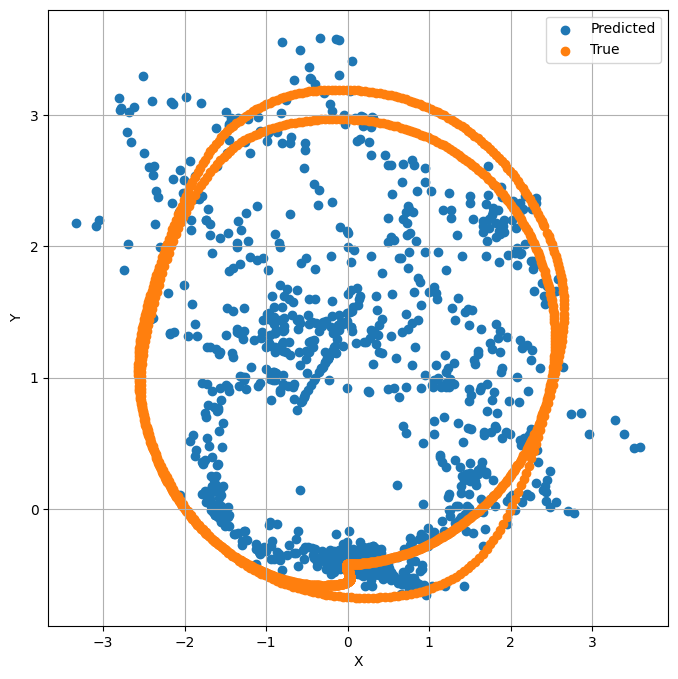

In [22]:
# Extract the x and y coordinates from the predicted and true labels
predicted_x = predicted_labels[:, 0]
predicted_y = predicted_labels[:, 1]
true_x = true_labels[:, 0]
true_y = true_labels[:, 1]

# Plot the predicted and true labels on an xy plane
plt.figure(figsize=(8, 8))
plt.scatter(predicted_x, predicted_y, label='Predicted')
plt.scatter(true_x, true_y, label='True')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()
